# Histopathologic Cancer Detection using various CNN models

Cancer is a disease in which cells are developed abnormally and they divide uncontrollably. This in turn has the ability to infiltrate and destroy normal body tissue. If detected early, it is highly treatable.

Deep learning in the field of image processing has shown exceptional results. The aim of this project is to do histopathologic cancer detection using Convolutional Neural Networks (CNN) and transfer learning. The goal is to create such a model that it can detect from a scan if the cancer tissue is found or not in the image, so that it is detected and appropriate medical treatment can be provided for its cure.

TensorFlow library is used for the deep learning. 

In this notebook, we will be extending our previous notebook submitted with Xception, VGG16 and resnet-50 Convolutional Neural Network (CNN). This will help us in conclusing the best model for our use case.

### Importing the libraries

The required libraries are imported.

In [1]:
# import libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Lambda, Dropout, Activation, Dense
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import model_from_json, load_model
import pandas as pd
import plotly.express as px
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from numpy.random import seed
seed(50)
# from tensorflow import set_random_seed
tf.random.set_seed(50)

import matplotlib.pyplot as plt

from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)

import random
from PIL import Image

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

### Data Exploration and Pre-processing

In [2]:
df_train = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

# removing this image because it caused a training error previously
df_train[df_train['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']

# removing this image because it is black
df_train[df_train['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0


In [3]:
df_train['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [4]:
label_map = {0:'Metastatic Tissue Not Found',1:'Metastatic Tissue Found'}
label_mapper = lambda y: list(map(lambda x:label_map.get(x), y))

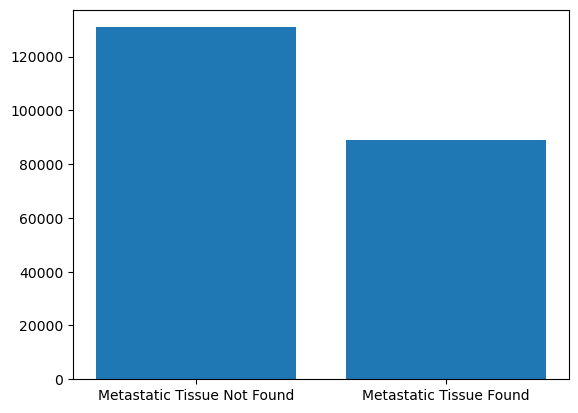

In [5]:
plt.bar(label_mapper(df_train['label'].value_counts().index.tolist()), df_train['label'].value_counts())
plt.show()

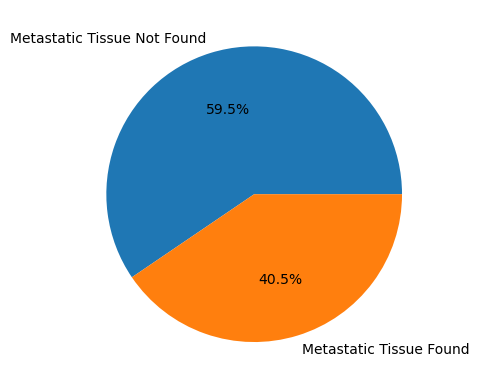

In [6]:
plt.pie(df_train['label'].value_counts(), labels=label_mapper(df_train['label'].value_counts().index.tolist()), autopct='%1.1f%%')
plt.show()

In [7]:
bal_sample_size = 85000

In [8]:
# take a random sample of class 0 with size equal to num samples in class 1
df_false = df_train[df_train['label'] == 0].sample(bal_sample_size, random_state = 50)

# filter out class 1
df_true = df_train[df_train['label'] == 1].sample(bal_sample_size, random_state = 50)

# concat the dataframes
df_train = pd.concat([df_false, df_true], axis=0).reset_index(drop=True)

# shuffle
df_train = shuffle(df_train)

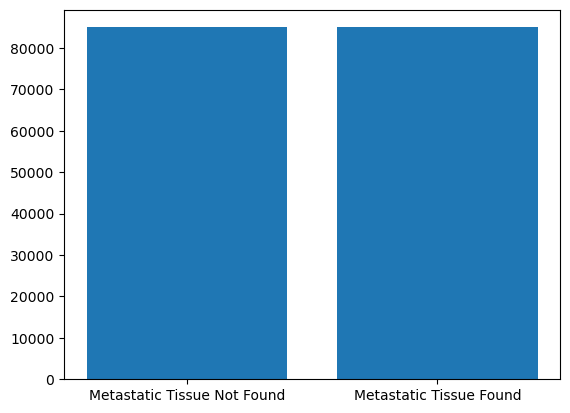

In [9]:
plt.bar(label_mapper(df_train['label'].value_counts().index.tolist()), df_train['label'].value_counts())
plt.show()

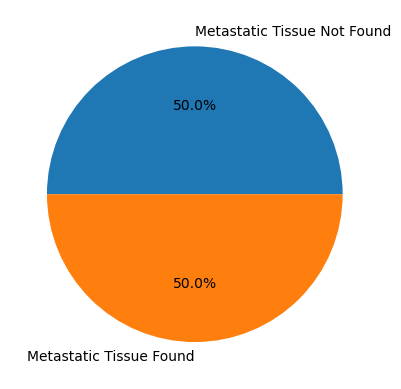

In [10]:
plt.pie(df_train['label'].value_counts(), labels=label_mapper(df_train['label'].value_counts().index.tolist()), autopct='%1.1f%%')
plt.show()

In [11]:
# train_test_split

# stratify=y creates a balanced validation set.
y = df_train['label']

df_train, df_val = train_test_split(df_train, test_size=0.20, random_state=50, stratify=y)

print(df_train.shape)
print(df_val.shape)

(136000, 2)
(34000, 2)


In [12]:
df_train['label'].value_counts()

0    68000
1    68000
Name: label, dtype: int64

In [13]:
df_val['label'].value_counts()

0    17000
1    17000
Name: label, dtype: int64

In [ ]:
%%bash

mkdir -p data_dir/train_dir/true 
mkdir -p data_dir/train_dir/false

mkdir -p data_dir/val_dir/true 
mkdir -p data_dir/val_dir/false


In [ ]:
def move_image(df:pd.DataFrame, dir_name):
    for index,row in df.iterrows():
        fname = row['id'] + '.tif'
        if row['label'] == 0:
            label = 'false'
        else:
            label = 'true'
        src = os.path.join('../input/histopathologic-cancer-detection/train', fname)
        dst = os.path.join(dir_name, label, fname)
        os.system(f"cp {src} {dst}")

move_image(df_train,'/kaggle/working/data_dir/train_dir')
move_image(df_val,'/kaggle/working/data_dir/val_dir')
    

In [14]:
print(len(os.listdir('data_dir/train_dir/true')))
print(len(os.listdir('data_dir/train_dir/false')))

68000
68000


In [15]:
print(len(os.listdir('data_dir/val_dir/true')))
print(len(os.listdir('data_dir/val_dir/false')))

17000
17000


In [12]:
def show_img(dir_name, imgs, plot_title):   
    images = []
    for image in os.listdir(dir_name):
        images.append(os.path.join(dir_name, image))

    plt.figure(1, figsize=(15, 9))
    plt.axis('off')
    n = 0
    for i in range(imgs):
        n += 1
        random_img = random.choice(images)
        imgs = Image.open(random_img)
        plt.subplot(3, 3, n)
        plt.axis('off')
        plt.imshow(imgs)
    
    plt.suptitle(plot_title)
    plt.show()

/tmp/ipykernel_29/3300387117.py:13: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



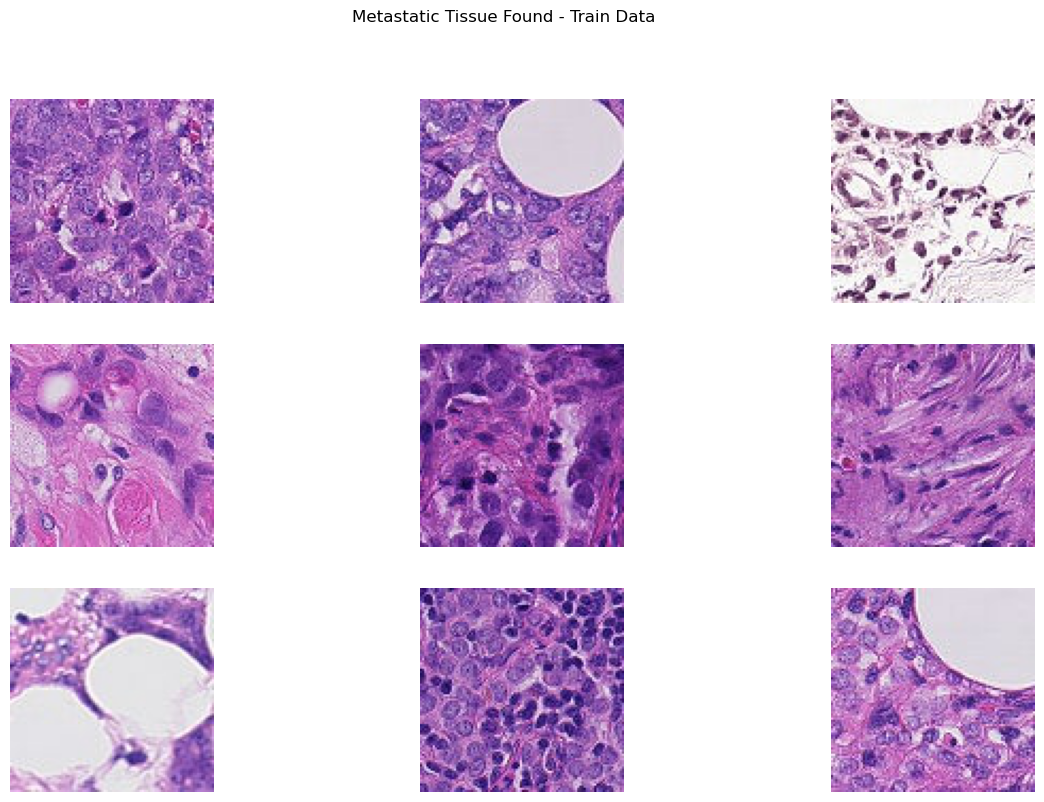

In [13]:
show_img('data_dir/train_dir/true', 9, 'Metastatic Tissue Found - Train Data')

/tmp/ipykernel_29/3300387117.py:13: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



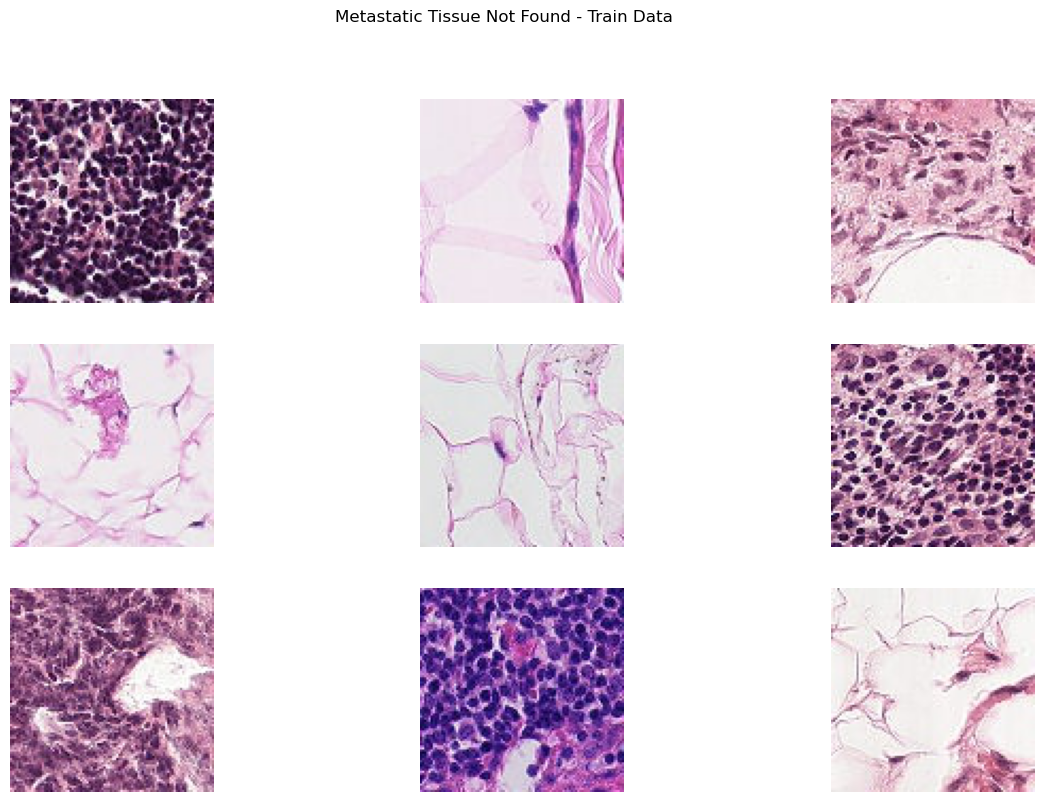

In [14]:
show_img('data_dir/train_dir/false', 9, 'Metastatic Tissue Not Found - Train Data')

### Creating the directories for Kaggle

Directories for train, test and output folders are created.

The image dimension is also set for 299 pixels based upon the data.

In [15]:
trainFolder = "data_dir/train_dir/"
testFolder = "data_dir/val_dir/"
outputDir = "/kaggle/working/"
imgDim = 96

### Generalized Mean Pooling

Generalized Mean Pooling computes the generalized mean of each channel of a tensor. It helps focus on the salient features of the image.

In [16]:
gm_exp = tf.Variable(3., dtype=tf.float32)
def generalized_mean_pool_2d(X):
    pool = (tf.reduce_mean(tf.abs(X**(gm_exp)), 
                           axis=[1,2], 
                           keepdims=False)+1.e-8)**(1./gm_exp)
    return pool

### Base Model for Xception

We have defined a function "getBaseModel_xception" that takes "freezedLayers" as attributes and those number of layers are freezed in the "Xception" CNN for transfer learning. The property "layer.trainable" is set as "False" for the layers that we want to freeze.

In [19]:
def getBaseModel_xception(freezedLayers):
    model = Xception(input_shape=(imgDim,imgDim,3),weights='imagenet',include_top=False)
    for layer in model.layers:
        layer.trainable = True
    for layer in model.layers[:freezedLayers]:
        layer.trainable = False   
    return model

### Additional Layers for Xception

A function "getAttachmentForModel_xception" is defined in which The additional layers are defined for training i.e., 3 hidden (dropout, activation and dense) layers and 1 output layer.

In [20]:
def getAttachmentForModel_xception(model):
    X_feat = Input(model.output_shape[1:])
    lambda_layer = Lambda(generalized_mean_pool_2d)
    lambda_layer.trainable_weights.extend([gm_exp])
    X = lambda_layer(X_feat)
    X = Dropout(0.05)(X)
    X = Activation('relu')(X)
    X = Dense(2, activation='softmax')(X)
    return Model(inputs=X_feat, outputs=X)

### Final Model for Xception

The "getFinalModel_xception" function takes the base model as input and creates a model with the freezed layers as well as the new layers that are required for the training of the model.

In [21]:
def getFinalModel_xception(baseModel):
    attachment = getAttachmentForModel_xception(baseModel)
    imageInput = Input((imgDim,imgDim,3))
    finalModel = baseModel(imageInput)
    finalModel = attachment(finalModel)
    finalModel = Model(inputs=imageInput, outputs=finalModel)
    return finalModel

### Save History

The "saveHistoryFile" fuction saves the history including the accuracy for each epoch into a csv file. This can be used later on for visualizations and drawing conclusions.

In [22]:
def saveHistoryFile(freezedLayers,model,filename):
    df = pd.DataFrame(model.history)
#     with open(f'{outputDir}{freezedLayers}.json','w') as f:
#     df.index.name = "Epoch"
#     df["Epoch"] = df.index
    df.insert(0,'Epoch',df.index)
#     df["freezed_layer"] = f"{freezedLayers}"
    df.insert(0,'freezed_layer', f"{freezedLayers}")
    if os.path.isfile(f'{outputDir}{filename}.csv'):
        exist_df = pd.read_csv(f'{outputDir}{filename}.csv')
        final_df = pd.concat([exist_df, df])
    else:
        final_df = df
    final_df.to_csv(f'{outputDir}{filename}.csv', index=False)


### Image Augmentation

This is a technique that is used to expand the dataset artificially. We have set the attributes of "rescale" to 1/255, "shear_range" to 0.2, "zoon_range" to 0.2 and "horizontal_flip" as True for both train dataset as well as test dataset.

We have defined the train and test folders, targert_size as 299 pixels by 299 pixels, batch_size as 48 images and class_mode as "categorical" for both train and test dataset.

In [17]:
trainGenerator = ImageDataGenerator(
    rescale = 1./255,                                     
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)

testGenerator = ImageDataGenerator(rescale = 1./255)

trainData = trainGenerator.flow_from_directory(
    trainFolder,
    target_size = (imgDim, imgDim),
    batch_size = 48,
    class_mode = 'categorical')

testData = testGenerator.flow_from_directory(
    testFolder, 
    target_size = (imgDim, imgDim),
    batch_size = 48, 
    class_mode = 'categorical',
    shuffle = False)


Found 136000 images belonging to 2 classes.
Found 34000 images belonging to 2 classes.


### Train the Model for Xception

Now, we are training the model. Xception CNN model has 132 layers, therefore, we are starting from 130 freezed layers and going down to 85 layers with the difference of 5 layers each time to reach the optimum result in which we have the best results.

The loss function used is "categorical_crossentropy" and the optimized is "adam".

In [18]:
xception_score_df = pd.DataFrame(columns=["Freezed Layers", "Loss", "Accuracy"])

for i in range(95,84,-5):
    print(f"Using {i} freezed layers")
    freezedLayers = i
    finalModel_xception = getFinalModel_xception(getBaseModel_xception(freezedLayers))
    finalModel_xception.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=[
            'binary_accuracy', 
            'AUC',
            tf.keras.metrics.TruePositives(name='true_positives'),
            tf.keras.metrics.TrueNegatives(name='true_negatives'),
            tf.keras.metrics.FalsePositives(name='false_positives'),
            tf.keras.metrics.FalseNegatives(name='false_negatives'),
        ]
    )
    trainedModel_xception = finalModel_xception.fit_generator(
        trainData,
        validation_data=testData,
        epochs=10,
    )
    saveHistoryFile(freezedLayers,trainedModel_xception,"Xception")
    
    score = finalModel_xception.evaluate(testData, verbose=0)
    xception_score_df.loc[len(xception_score_df.index)] = [freezedLayers, score[0], score[1]]
    
    finalModel_xception.save(f'xception_model_{i}_FL.h5', save_format='h5')

Using 95 freezed layers
83683744/83683744 [==============================] - 4s 0us/step


/tmp/ipykernel_29/1117569943.py:19: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/10
2834/2834 [==============================] - 506s 172ms/step - loss: 0.3161 - binary_accuracy: 0.8651 - auc: 0.9391 - true_positives: 117654.0000 - true_negatives: 117654.0000 - false_positives: 18346.0000 - false_negatives: 18346.0000 - val_loss: 0.2970 - val_binary_accuracy: 0.8785 - val_auc: 0.9504 - val_true_positives: 29869.0000 - val_true_negatives: 29869.0000 - val_false_positives: 4131.0000 - val_false_negatives: 4131.0000
Epoch 2/10
2834/2834 [==============================] - 495s 175ms/step - loss: 0.2548 - binary_accuracy: 0.8953 - auc: 0.9604 - true_positives: 121757.0000 - true_negatives: 121757.0000 - false_positives: 14243.0000 - false_negatives: 14243.0000 - val_loss: 0.2671 - val_binary_accuracy: 0.8961 - val_auc: 0.9567 - val_true_positives: 30467.0000 - val_true_negatives: 30467.0000 - val_false_positives: 3533.0000 - val_false_negatives: 3533.0000
Epoch 3/10
2834/2834 [==============================] - 495s 175ms/step - loss: 0.2319 - binary_accuracy: 0.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2834/2834 [==============================] - 501s 177ms/step - loss: 0.1701 - binary_accuracy: 0.9325 - auc: 0.9821 - true_positives: 126826.0000 - true_negatives: 126826.0000 - false_positives: 9174.0000 - false_negatives: 9174.0000 - val_loss: 0.1846 - val_binary_accuracy: 0.9260 - val_auc: 0.9791 - val_true_positives: 31485.0000 - val_true_negatives: 31485.0000 - val_false_positives: 2515.0000 - val_false_negatives: 2515.0000
Epoch 10/10
2834/2834 [==============================] - 506s 179ms/step - loss: 0.1636 - binary_accuracy: 0.9350 - auc: 0.9835 - true_positives: 127166.0000 - true_negatives: 127166.0000 - false_positives: 8834.0000 - false_negatives: 8834.0000 - val_loss: 0.1837 - val_binary_accuracy: 0.9296 - val_auc: 0.9793 - val_true_positives: 31606.0000 - val_true_negatives: 31606.0000 - val_false_positives: 2394.0000 - val_false_negatives: 2394.0000
Using 90 freezed layers
Epoch 1/10


/tmp/ipykernel_29/1117569943.py:19: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



2834/2834 [==============================] - 515s 177ms/step - loss: 0.3169 - binary_accuracy: 0.8656 - auc: 0.9389 - true_positives: 117728.0000 - true_negatives: 117728.0000 - false_positives: 18272.0000 - false_negatives: 18272.0000 - val_loss: 0.2646 - val_binary_accuracy: 0.8932 - val_auc: 0.9590 - val_true_positives: 30370.0000 - val_true_negatives: 30370.0000 - val_false_positives: 3630.0000 - val_false_negatives: 3630.0000
Epoch 2/10
2834/2834 [==============================] - 503s 177ms/step - loss: 0.2540 - binary_accuracy: 0.8964 - auc: 0.9606 - true_positives: 121913.0000 - true_negatives: 121913.0000 - false_positives: 14087.0000 - false_negatives: 14087.0000 - val_loss: 0.2323 - val_binary_accuracy: 0.9093 - val_auc: 0.9672 - val_true_positives: 30916.0000 - val_true_negatives: 30916.0000 - val_false_positives: 3084.0000 - val_false_negatives: 3084.0000
Epoch 3/10
2834/2834 [==============================] - 502s 177ms/step - loss: 0.2285 - binary_accuracy: 0.9077 - auc:

/tmp/ipykernel_29/1117569943.py:19: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/10
2834/2834 [==============================] - 481s 165ms/step - loss: 0.3159 - binary_accuracy: 0.8656 - auc: 0.9392 - true_positives: 117719.0000 - true_negatives: 117719.0000 - false_positives: 18281.0000 - false_negatives: 18281.0000 - val_loss: 0.2826 - val_binary_accuracy: 0.8777 - val_auc: 0.9519 - val_true_positives: 29842.0000 - val_true_negatives: 29842.0000 - val_false_positives: 4158.0000 - val_false_negatives: 4158.0000
Epoch 2/10
2834/2834 [==============================] - 474s 167ms/step - loss: 0.2531 - binary_accuracy: 0.8957 - auc: 0.9609 - true_positives: 121820.0000 - true_negatives: 121820.0000 - false_positives: 14180.0000 - false_negatives: 14180.0000 - val_loss: 0.2208 - val_binary_accuracy: 0.9099 - val_auc: 0.9703 - val_true_positives: 30935.0000 - val_true_negatives: 30935.0000 - val_false_positives: 3065.0000 - val_false_negatives: 3065.0000
Epoch 3/10
2834/2834 [==============================] - 469s 165ms/step - loss: 0.2291 - binary_accuracy: 0.

In [ ]:
xception_score_df

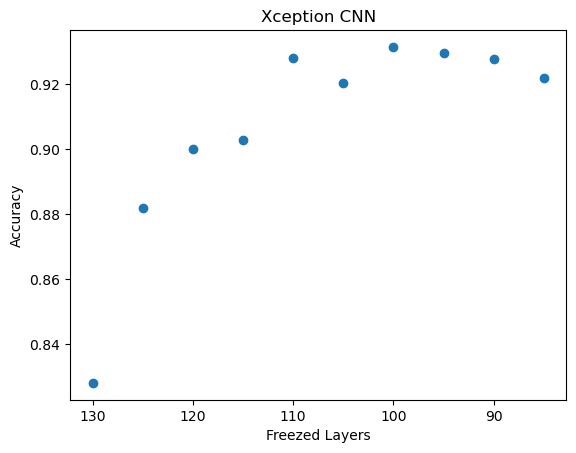

In [35]:
xception_df = pd.read_csv("Xception.csv")
plt.scatter(xception_df[xception_df["Epoch"] == 9]["freezed_layer"], xception_df[xception_df["Epoch"] == 9]["val_binary_accuracy"])
plt.gca().invert_xaxis()
plt.xlabel('Freezed Layers')
plt.ylabel('Accuracy')
plt.title('Xception CNN')
plt.show()

In [25]:
def conf_mat_report(model, testData):
    Y_pred = model.predict_generator(testData, steps=len(testData))
    y_pred = np.argmax(Y_pred, axis=1)
    CM = confusion_matrix(testData.classes, y_pred)
    labels = ['Not Found','Found']
    disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=labels)
    disp.plot()
    plt.show()
    print(classification_report(testData.classes, y_pred, target_names=labels))

In [26]:
finalModel_xception = load_model('xception_model_100_FL.h5')

/tmp/ipykernel_28/3664884643.py:2: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



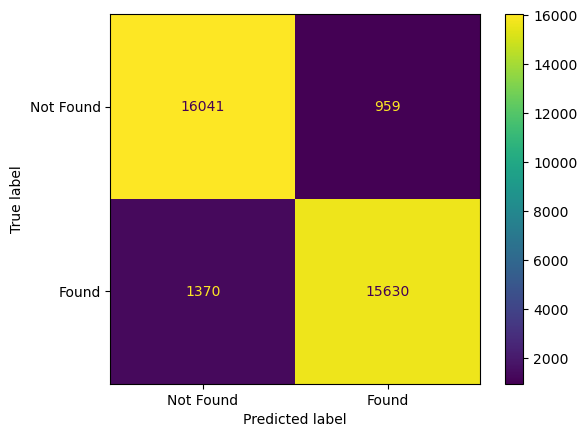

              precision    recall  f1-score   support

   Not Found       0.92      0.94      0.93     17000
       Found       0.94      0.92      0.93     17000

    accuracy                           0.93     34000
   macro avg       0.93      0.93      0.93     34000
weighted avg       0.93      0.93      0.93     34000



In [27]:
conf_mat_report(finalModel_xception, testData)

# Summary for Xception CNN

The summary of our findings can be shown as below:

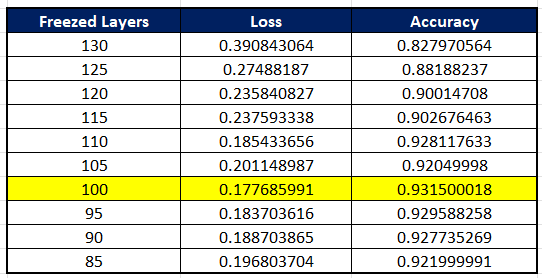

The column "Freezed Layers" signifies that how many layers were freezed for the training. The columns "Loss" and "Accuracy" signifies the loss and accuracy for those approaches.

##### Based upon our findings, we conclude that the best optimum results can be achieved with 100 freezed layers with Accuracy = 0.177685990929603 and Loss = 0.177685990929603.

# VGG-16

VGG16 is a convolutional neural network model that is used for image recognition. It is unique in that it has only 16 layers that have weights, as opposed to relying on a large number of hyper-parameters. It is also considered one of the best vision model architectures.

### Base Model for VGG16

We have defined a function "getBaseModel_VGG" that takes "freezedLayers" as attributes and those number of layers are freezed in the "Xception" CNN for transfer learning. The property "layer.trainable" is set as "False" for the layers that we want to freeze.

In [28]:
def getBaseModel_VGG(freezedLayers):
    model = VGG16(weights="imagenet", include_top=False, input_shape=(imgDim,imgDim,3))
    for layer in model.layers:
        layer.trainable = True
    for layer in model.layers[:freezedLayers]:
        layer.trainable = False   
    return model

### Additional Layers for VGG16

A function "getAttachmentForModel_VGG" is defined in which The additional layers are defined for training i.e., 3 hidden (dropout, dense and dense) layers and 1 output layer.

In [29]:
def getAttachmentForModel_VGG(model):
    X_feat = Input(model.output_shape[1:])
    lambda_layer = Lambda(generalized_mean_pool_2d)
    lambda_layer.trainable_weights.extend([gm_exp])
    X = lambda_layer(X_feat)
    X = layers.Flatten()(X)
    X = layers.Dense(50, activation='relu')(X)
    X = layers.Dense(20, activation='relu')(X)
    X = Dense(2, activation='softmax')(X)
    return Model(inputs=X_feat, outputs=X)

### Final Model for VGG16

The "getFinalModel_VGG" function takes the base model as input and creates a model with the freezed layers as well as the new layers that are required for the training of the model.

In [30]:
def getFinalModel_VGG(baseModel):
    attachment = getAttachmentForModel_VGG(baseModel)
    imageInput = Input((imgdim,imgdim,3))
    finalModel = baseModel(imageInput)
    finalModel = attachment(finalModel)
    finalModel = Model(inputs=imageInput, outputs=finalModel)
    return finalModel

### Train the Model for VGG16

Now, we are training the model. VGG16 CNN model has 16 layers, therefore, we are starting from 14 freezed layers and going down to 10 layers with the difference of 2 layers each time to reach the optimum result in which we have the best results.

The loss function used is "categorical_crossentropy" and the optimized is "adam".

In [ ]:
vgg_score_df = pd.DataFrame(columns=["Freezed Layers", "Loss", "Accuracy"])

for i in range(14,9,-2):
    print(f"Using {i} freezed layers")
    freezedLayers = i
    finalModel_vgg = getFinalModel_VGG(getBaseModel_VGG(freezedLayers))
    finalModel_vgg.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=[
            'binary_accuracy', 
            'AUC',
            tf.keras.metrics.TruePositives(name='true_positives'),
            tf.keras.metrics.TrueNegatives(name='true_negatives'),
            tf.keras.metrics.FalsePositives(name='false_positives'),
            tf.keras.metrics.FalseNegatives(name='false_negatives'),
        ]
    )
    trainedModel_vgg = finalModel_vgg.fit_generator(
        trainData,
        validation_data=testData,
        epochs=10,
    )
    saveHistoryFile(freezedLayers,trainedModel_vgg,"vgg")
    
    score = finalModel_vgg.evaluate(testData, verbose=0)
    vgg_score_df.loc[len(vgg_score_df.index)] = [freezedLayers, score[0], score[1]]
    
    finalModel_vgg.save(f'vgg_model_{i}_FL.h5', save_format='h5')

Using 14 freezed layers
58889256/58889256 [==============================] - 2s 0us/step


/tmp/ipykernel_29/2676062828.py:19: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/10
2834/2834 [==============================] - 478s 165ms/step - loss: 0.3389 - binary_accuracy: 0.8521 - auc: 0.9294 - true_positives: 115887.0000 - true_negatives: 115887.0000 - false_positives: 20113.0000 - false_negatives: 20113.0000 - val_loss: 0.3072 - val_binary_accuracy: 0.8738 - val_auc: 0.9452 - val_true_positives: 29708.0000 - val_true_negatives: 29708.0000 - val_false_positives: 4292.0000 - val_false_negatives: 4292.0000
Epoch 2/10
1021/2834 [=========>....................] - ETA: 4:34 - loss: 0.2978 - binary_accuracy: 0.8746 - auc: 0.9460 - true_positives: 42863.0000 - true_negatives: 42863.0000 - false_positives: 6145.0000 - false_negatives: 6145.0000

In [ ]:
vgg_score_df

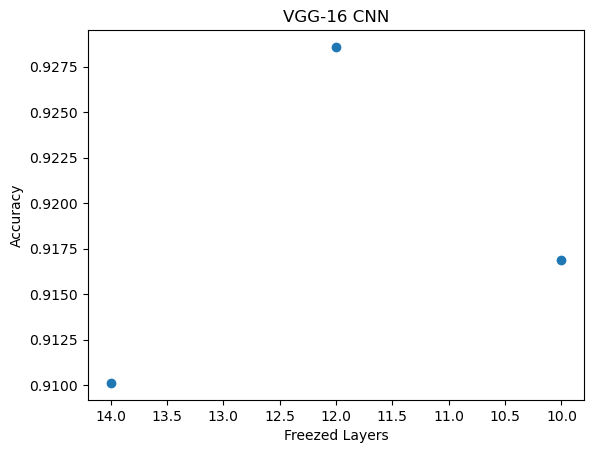

In [36]:
vgg_df = pd.read_csv("vgg.csv")
plt.scatter(vgg_df[vgg_df["Epoch"] == 9]["freezed_layer"], vgg_df[vgg_df["Epoch"] == 9]["val_binary_accuracy"])
plt.gca().invert_xaxis()
plt.xlabel('Freezed Layers')
plt.ylabel('Accuracy')
plt.title('VGG-16 CNN')
plt.show()

In [33]:
finalModel_vgg = load_model('vgg_model_12_FL.h5')

/tmp/ipykernel_28/3664884643.py:2: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



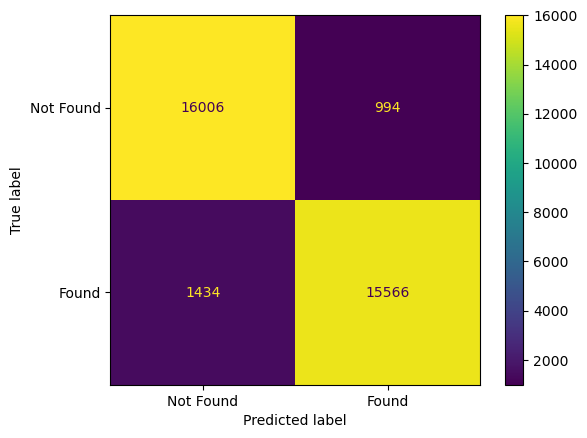

              precision    recall  f1-score   support

   Not Found       0.92      0.94      0.93     17000
       Found       0.94      0.92      0.93     17000

    accuracy                           0.93     34000
   macro avg       0.93      0.93      0.93     34000
weighted avg       0.93      0.93      0.93     34000



In [34]:
conf_mat_report(finalModel_vgg, testData)

# Summary for VGG16 CNN

The summary of our findings can be shown as below:

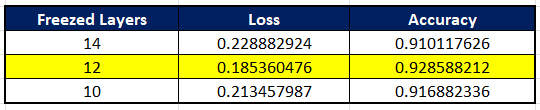

The column "Freezed Layers" signifies that how many layers were freezed for the training. The columns "Loss" and "Accuracy" signifies the loss and accuracy for those approaches.

##### Based upon our findings, we conclude that the best optimum results can be achieved with 12 freezed layers with Accuracy = 0.928588211536407 and Loss = 0.185360476374626.

# Resnet-50

ResNet-50 is a 50-layer convolutional neural network (48 convolutional layers, one MaxPool layer, and one average pool layer). Residual neural networks are a type of artificial neural network (ANN) that forms networks by stacking residual blocks.

### Base Model for resnet-50

We have defined a function "getBaseModel_resnet" that takes "freezedLayers" as attributes and those number of layers are freezed in the "Xception" CNN for transfer learning. The property "layer.trainable" is set as "False" for the layers that we want to freeze.

In [37]:
def getBaseModel_resnet(freezedLayers):
    model = ResNet50(weights="imagenet", include_top=False, input_shape=(imgDim,imgDim,3))
    for layer in model.layers:
        layer.trainable = True
    for layer in model.layers[:freezedLayers]:
        layer.trainable = False   
    return model

### Additional Layers for Resnet-50

A function "getAttachmentForModel_resnet" is defined in which The additional layers are defined for training i.e., 4 hidden (flatten, dense, dropout and dense) layers and 1 output layer.

In [38]:
def getAttachmentForModel_resnet(model):
    X_feat = Input(model.output_shape[1:])
    lambda_layer = Lambda(generalized_mean_pool_2d)
    lambda_layer.trainable_weights.extend([gm_exp])
    X = lambda_layer(X_feat)
    X = layers.Flatten()(X)
    X = layers.Dense(128, activation='relu')(X)
    X = Dropout(0.05)(X)
    X = layers.Dense(20, activation='relu')(X)
    X = Dense(2, activation='softmax')(X)
    return Model(inputs=X_feat, outputs=X)

### Final Model for Resnet-50

The "getFinalModel_resnet" function takes the base model as input and creates a model with the freezed layers as well as the new layers that are required for the training of the model.

In [39]:
def getFinalModel_resnet(baseModel):
    attachment = getAttachmentForModel_resnet(baseModel)
    imageInput = Input((imgdim,imgdim,3))
    finalModel = baseModel(imageInput)
    finalModel = attachment(finalModel)
    finalModel = Model(inputs=imageInput, outputs=finalModel)
    return finalModel

### Train the Model for Resnet-50

Now, we are training the model. Resnet-50 CNN model has 50 layers, therefore, we are starting from 45 freezed layers and going down to 33 layers with the difference of 4 layers each time to reach the optimum result in which we have the best results.

The loss function used is "categorical_crossentropy" and the optimized is "adam".

In [16]:
resnet_score_df = pd.DataFrame(columns=["Freezed Layers", "Loss", "Accuracy"])

for i in range(45,35,-4):
    print(f"Using {i} freezed layers")
    freezedLayers = i
    finalModel_resnet = getFinalModel_resnet(getBaseModel_resnet(freezedLayers))
    finalModel_resnet.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=[
            'binary_accuracy', 
            'AUC',
            tf.keras.metrics.TruePositives(name='true_positives'),
            tf.keras.metrics.TrueNegatives(name='true_negatives'),
            tf.keras.metrics.FalsePositives(name='false_positives'),
            tf.keras.metrics.FalseNegatives(name='false_negatives'),
        ]
    )
    trainedModel_resnet = finalModel_resnet.fit_generator(
        trainData,
        validation_data=testData,
        epochs=10,
    )
    saveHistoryFile(freezedLayers,trainedModel_resnet,"resnet")
    
    score = finalModel_resnet.evaluate(testData, verbose=0)
    resnet_score_df.loc[len(resnet_score_df.index)] = [freezedLayers, score[0], score[1]]
    
    finalModel_resnet.save(f'resnet_model_{i}_FL.h5', save_format='h5')

Using 45 freezed layers
94765736/94765736 [==============================] - 3s 0us/step


/tmp/ipykernel_28/3719010345.py:19: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/10
2834/2834 [==============================] - 536s 176ms/step - loss: 0.4255 - binary_accuracy: 0.8082 - auc: 0.8868 - true_positives: 109915.0000 - true_negatives: 109915.0000 - false_positives: 26085.0000 - false_negatives: 26085.0000 - val_loss: 0.6110 - val_binary_accuracy: 0.6604 - val_auc: 0.7409 - val_true_positives: 22453.0000 - val_true_negatives: 22453.0000 - val_false_positives: 11547.0000 - val_false_negatives: 11547.0000
Epoch 2/10
2834/2834 [==============================] - 498s 176ms/step - loss: 0.3473 - binary_accuracy: 0.8488 - auc: 0.9260 - true_positives: 115437.0000 - true_negatives: 115437.0000 - false_positives: 20563.0000 - false_negatives: 20563.0000 - val_loss: 1.4254 - val_binary_accuracy: 0.5587 - val_auc: 0.5991 - val_true_positives: 18997.0000 - val_true_negatives: 18997.0000 - val_false_positives: 15003.0000 - val_false_negatives: 15003.0000
Epoch 3/10
2834/2834 [==============================] - 502s 177ms/step - loss: 0.3247 - binary_accuracy

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2834/2834 [==============================] - 522s 173ms/step - loss: 0.4431 - binary_accuracy: 0.7958 - auc: 0.8766 - true_positives: 108227.0000 - true_negatives: 108227.0000 - false_positives: 27773.0000 - false_negatives: 27773.0000 - val_loss: 2.0109 - val_binary_accuracy: 0.5383 - val_auc: 0.6627 - val_true_positives: 18303.0000 - val_true_negatives: 18303.0000 - val_false_positives: 15697.0000 - val_false_negatives: 15697.0000
Epoch 2/10
2834/2834 [==============================] - 493s 174ms/step - loss: 0.3635 - binary_accuracy: 0.8404 - auc: 0.9186 - true_positives: 114294.0000 - true_negatives: 114294.0000 - false_positives: 21706.0000 - false_negatives: 21706.0000 - val_loss: 0.6929 - val_binary_accuracy: 0.5460 - val_auc: 0.6133 - val_true_positives: 18563.0000 - val_true_negatives: 18563.0000 - val_false_positives: 15437.0000 - val_false_negatives: 15437.0000
Epoch 3/10
2834/2834 [==============================] - 491s 173ms/step - loss: 0.3329 - binary_accuracy: 0.8562 - 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2834/2834 [==============================] - 503s 177ms/step - loss: 0.3806 - binary_accuracy: 0.8341 - auc: 0.9110 - true_positives: 113432.0000 - true_negatives: 113432.0000 - false_positives: 22568.0000 - false_negatives: 22568.0000 - val_loss: 0.6847 - val_binary_accuracy: 0.5012 - val_auc: 0.5812 - val_true_positives: 17041.0000 - val_true_negatives: 17041.0000 - val_false_positives: 16959.0000 - val_false_negatives: 16959.0000
Epoch 3/10
2834/2834 [==============================] - 506s 178ms/step - loss: 0.3459 - binary_accuracy: 0.8505 - auc: 0.9264 - true_positives: 115666.0000 - true_negatives: 115666.0000 - false_positives: 20334.0000 - false_negatives: 20334.0000 - val_loss: 1.5172 - val_binary_accuracy: 0.5126 - val_auc: 0.6599 - val_true_positives: 17428.0000 - val_true_negatives: 17428.0000 - val_false_positives: 16572.0000 - val_false_negatives: 16572.0000
Epoch 4/10
2834/2834 [==============================] - 506s 179ms/step - loss: 0.3111 - binary_accuracy: 0.8679 - 

In [ ]:
resnet_score_df

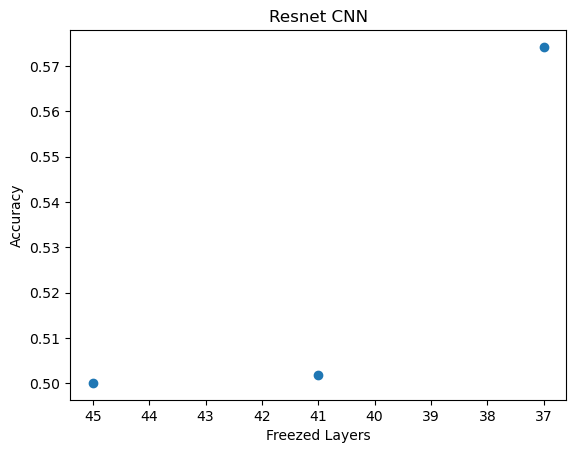

In [40]:
resnet_df = pd.read_csv("resnet.csv")
plt.scatter(resnet_df[resnet_df["Epoch"] == 9]["freezed_layer"], resnet_df[resnet_df["Epoch"] == 9]["val_binary_accuracy"])
plt.gca().invert_xaxis()
plt.xlabel('Freezed Layers')
plt.ylabel('Accuracy')
plt.title('Resnet CNN')
plt.show()

In [41]:
finalModel_resnet = load_model('resnet_model_37_FL.h5')

/tmp/ipykernel_28/3664884643.py:2: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



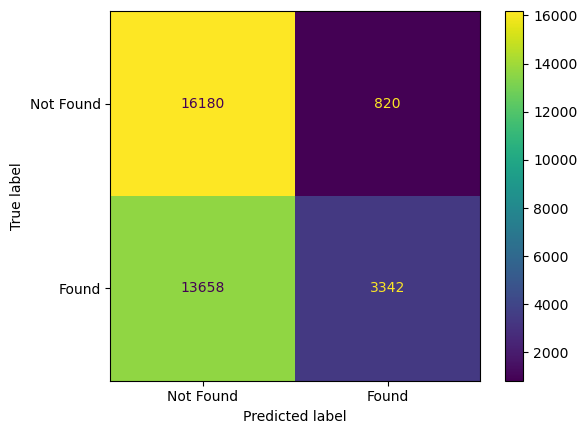

              precision    recall  f1-score   support

   Not Found       0.54      0.95      0.69     17000
       Found       0.80      0.20      0.32     17000

    accuracy                           0.57     34000
   macro avg       0.67      0.57      0.50     34000
weighted avg       0.67      0.57      0.50     34000



In [42]:
conf_mat_report(finalModel_resnet, testData)

# Summary for Resnet-50 CNN

The summary of our findings can be shown as below:

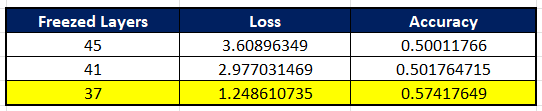

The column "Freezed Layers" signifies that how many layers were freezed for the training. The columns "Loss" and "Accuracy" signifies the loss and accuracy for those approaches.

##### Based upon our findings, we conclude that the best optimum results can be achieved with 37 freezed layers with Accuracy = 0.574176490306854 and Loss = 1.24861073493957.

# Benchmarking Conclusion

The results found for Xception, VGG16 and Resnet-50 can be summarized as below:

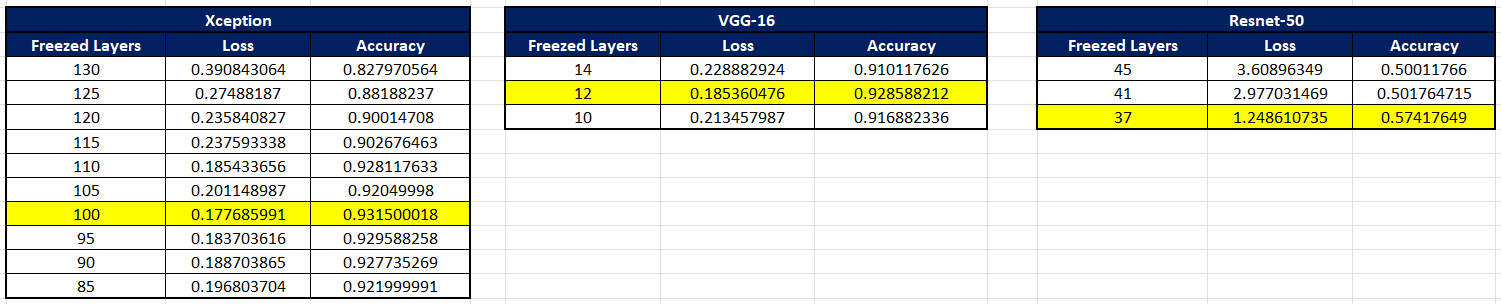

The yellow highlighted row is the best result for each model.

### The best model is the Xception Convolution Neural Network with 100 freezed layers having the Accuracy of 0.931500017642974 and the Loss of 0.177685990929603.

# Best Benchmarked Model Training

In [ ]:
freezedLayers = 100
print(f"Using {freezedLayers} freezed layers")
finalModel_xception = getFinalModel_xception(getBaseModel_xception(freezedLayers))
finalModel_xception.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[
        'binary_accuracy', 
        'AUC',
        tf.keras.metrics.TruePositives(name='true_positives'),
        tf.keras.metrics.TrueNegatives(name='true_negatives'),
        tf.keras.metrics.FalsePositives(name='false_positives'),
        tf.keras.metrics.FalseNegatives(name='false_negatives'),
    ]
)
trainedModel_xception = finalModel_xception.fit_generator(
    trainData,
    validation_data=testData,
    epochs=75,
)

saveHistoryFile(freezedLayers,trainedModel_xception,"Xception_best")
    
finalModel_xception.save(f'xception_best_model_100_FL.h5', save_format='h5')

In [22]:
finalModel_best_xception = load_model('xception_best_model_100_FL.h5')

/tmp/ipykernel_28/3664884643.py:2: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



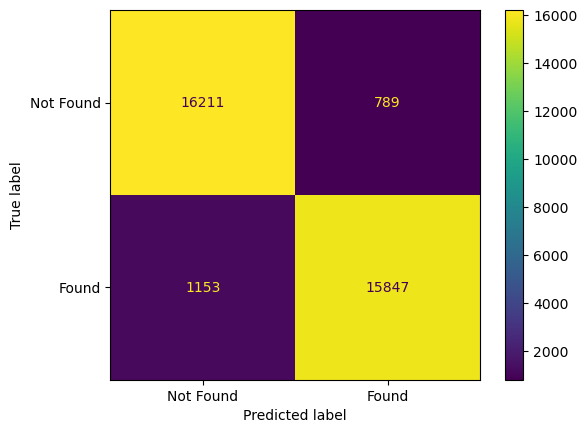

              precision    recall  f1-score   support

   Not Found       0.93      0.95      0.94     17000
       Found       0.95      0.93      0.94     17000

    accuracy                           0.94     34000
   macro avg       0.94      0.94      0.94     34000
weighted avg       0.94      0.94      0.94     34000



In [46]:
conf_mat_report(finalModel_best_xception, testData)

# Predictions

Predicting a few images.

In [69]:
def predictions(dir_name, imgs, model, plot_title):   
    
    predGenerator = ImageDataGenerator(rescale = 1./255)
    predData = predGenerator.flow_from_directory(
        dir_name, 
        target_size = (imgDim, imgDim),
        batch_size = 48, 
        class_mode = 'categorical',
        shuffle = False)
    fileNames = list(map(lambda x : ''.join((''.join(x.split('.')[:-1])).split('/')[1:]), predData.filenames))
    
    Y_pred = model.predict_generator(predData, steps=len(testData))
    y_pred = np.argmax(Y_pred, axis=1)
    
    predData.reset()
    batch = next(predData)
    
    plt.figure(1, figsize=(15, 9))
    plt.axis('off')
    
    df_pred = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

    for i in range(imgs):
        image_data = batch[0][i]
        know_class = np.argmax(batch[1][i])
        predicted_class = y_pred[i]
        plt.subplot(3, 3, i+1)
        plt.axis('off')
        expected = list(df_pred[df_pred['id'] == fileNames[i]]['label'])[0]
        plt.title(f'Expected : {label_mapper([int(expected)])[0]} \n Predicted : {label_mapper([int(predicted_class)])[0]}')
        plt.imshow(image_data)
        
    plt.suptitle(plot_title)
    plt.show()

Found 9 images belonging to 1 classes.


/tmp/ipykernel_29/2967605241.py:12: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.

/tmp/ipykernel_29/2967605241.py:27: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



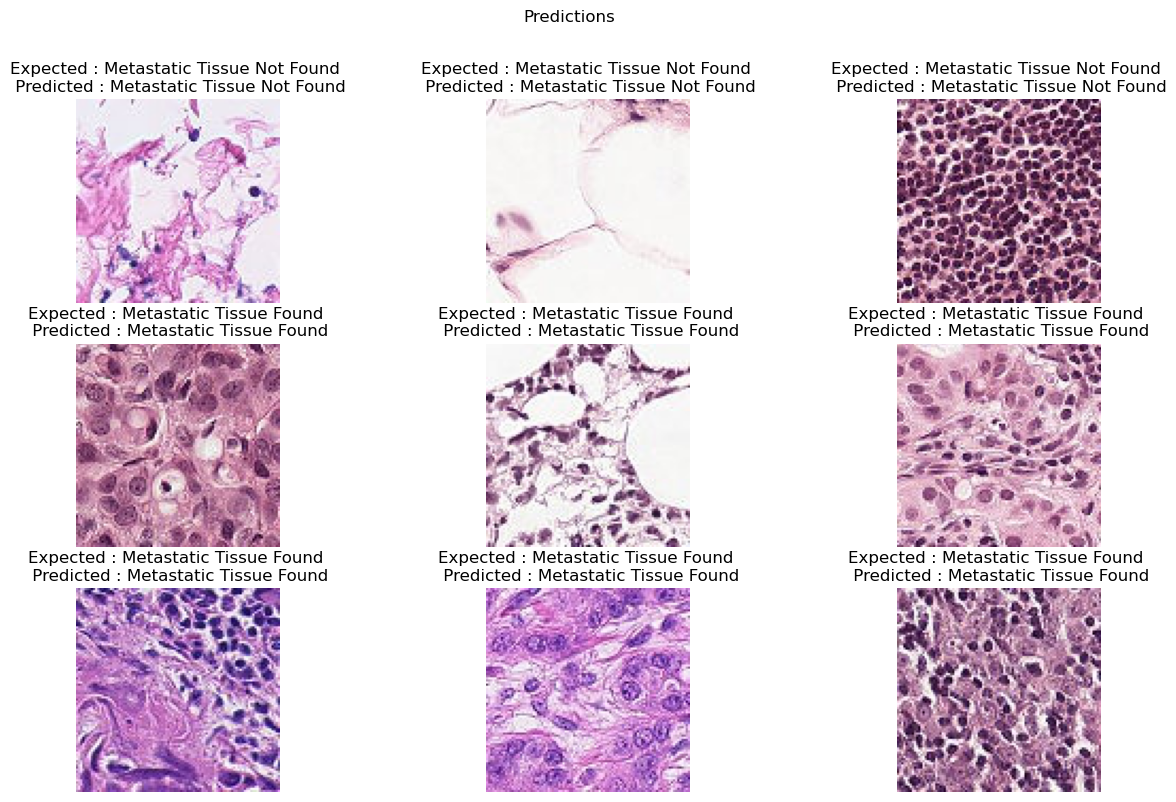

In [70]:
predictions('predict', 9, finalModel_best_xception, 'Predictions')

# Future Scope

The future scope involves training for more epochs, however, that would require more computational power and we can explore that option if given more time.

Furthermore, this application can be deployed to test and eventually production environment if it passes all the necessary approvals and compliances.

# References

1. https://www.kaggle.com/code/danushkumarv/skin-cancer-detection-deep-cnn/notebook This notebook is used for the code guidance and as a baseline configuration.

2. https://www.kaggle.com/competitions/histopathologic-cancer-detection/data Dataset for histopathologic cancer detection was used from here.